# `artemis`: demo and examples

`artemis` documentation is available at https://pyartemis.github.io.

In [1]:
##installation of the newest version from PyPI 
#!pip install --upgrade pyartemis  

In [2]:
from importlib.metadata import version
version('pyartemis') # version 0.1.3

'0.1.3'

### Imports of methods for extraction of interactions implemented in `artemis`

In [3]:
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod, GreenwellMethod, SejongOhMethod
from artemis.interactions_methods.model_specific import ConditionalMinimalDepthMethod, SplitScoreMethod

### Other imports 

In [4]:
# dataset 
from sklearn.datasets import fetch_california_housing 
# models 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
# utils
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import dalex as dx

## Regression task 
### California housing dataset 

In [5]:
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
X_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
17689,3.9250,18.0,4.900178,1.128342,1779.0,3.171123,37.28,-121.84
8913,2.7500,27.0,3.296980,1.058725,1042.0,1.748322,34.03,-118.46
17764,2.5551,35.0,4.018487,1.016807,1886.0,3.169748,37.35,-121.86
6453,3.6639,25.0,5.126482,1.117260,1848.0,2.434783,34.12,-118.06
14550,5.2648,12.0,5.608808,1.132124,792.0,2.051813,32.94,-117.24


### Model fitting and evaluation

We will create 3 different models: 
- random forest, 
- XGBoost,  
- linear regression as a baseline. 

In [8]:
lr_model = LinearRegression().fit(X_train, y_train)
rf_model = RandomForestRegressor(n_estimators=80, max_depth=4, max_features="sqrt").fit(X_train, y_train)
xgb_model = XGBRegressor(max_depth=3).fit(X_train, y_train)

In [9]:
lr_exp = dx.Explainer(lr_model, X_test, y_test, verbose=False)
rf_exp = dx.Explainer(rf_model, X_test, y_test, verbose=False)
xgb_exp = dx.Explainer(xgb_model, X_test, y_test, verbose=False)
lr_perf = lr_exp.model_performance()
rf_perf = rf_exp.model_performance()
xgb_perf = xgb_exp.model_performance()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [10]:
pd.concat([lr_perf.result, rf_perf.result, xgb_perf.result])

,mse,rmse,r2,mae,mad
LinearRegression,0.548434,0.740563,0.584706,0.535174,0.413352
RandomForestRegressor,0.588067,0.766855,0.554695,0.579504,0.466386
XGBRegressor,0.247214,0.497206,0.812801,0.341210,0.234241


In [11]:
fig = lr_perf.plot([rf_perf, xgb_perf], show=False)
fig.update_layout(xaxis_range=[0, 3])

Random forest and XGBoost achieve comparable results, with a slight indication in favor of XGBoost. 
Both models are clearly superior to linear regression. 

### Interaction explanations
Both model-agnostic and model-specific interaction explanations are available in the Artemis package. In this demo, we will show both types of methods. 

In [12]:
X_exp = X_test.sample(100) # sample for calculating explanations

#### Model-agnostic explanations

##### Partial dependence based

**Greenwell method** 


This is a method proposed by [Greenwell et al.](https://arxiv.org/abs/1805.04755). It is based on the concept of feature 
importance, understood as the variance of the partial dependence function. It measures the
variance of the feature importance of one feature conditional on the other to get pairwise interaction.

In [13]:
grenwell_method = GreenwellMethod()
grenwell_method.fit(xgb_model, X = X_exp, show_progress=True) 

Calculating feature importance: 100%|██████████| 8/8 [00:00<00:00, 43.79it/s]


Measures of the strength of the interaction of pairs of variables can be previewed in the `ovo` attribute of the created object. 

In [14]:
grenwell_method.ovo.head(10)

,Feature 1,Feature 2,Greenwell Variable Interaction Measure
0,Latitude,Longitude,0.215741
1,HouseAge,AveOccup,0.096934
2,MedInc,HouseAge,0.085356
3,MedInc,AveOccup,0.076949
4,HouseAge,Latitude,0.054782
5,AveOccup,Longitude,0.046912
6,AveOccup,Latitude,0.041600
7,AveRooms,Latitude,0.039433
8,MedInc,AveRooms,0.033778
9,MedInc,Longitude,0.029823


Along with interaction strength, the importance of individual features are also calculated, which are based on a similar concept to the given measure of interaction strength. It is saved in the `feature_importance` attribute.

In [15]:
grenwell_method.feature_importance

,Feature,Importance
0,Latitude,0.878564
1,Longitude,0.806006
2,MedInc,0.560201
3,AveOccup,0.280433
4,AveRooms,0.117601
5,HouseAge,0.083297
6,AveBedrms,0.040757
7,Population,0.023352


However, a much more convenient way to interpret the explanations may be to use visualizations. The package provides the ability to create various types of them. Below are the visualizations available for each method, presented along with some of their customization options. 

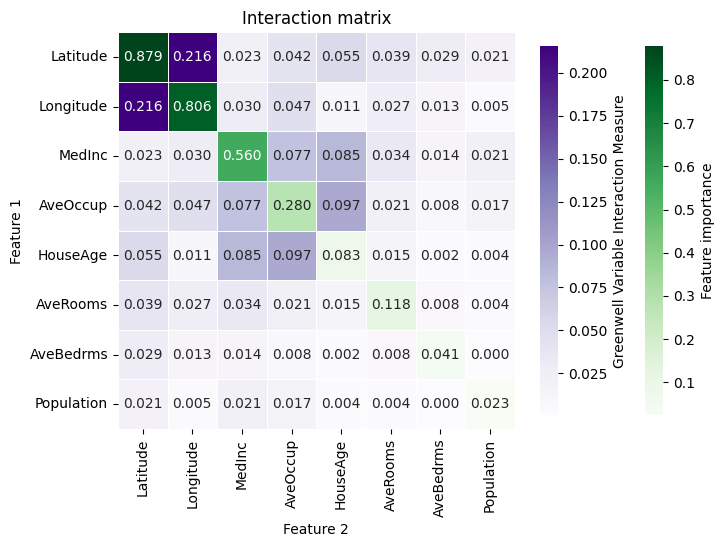

In [16]:
grenwell_method.plot(vis_type='heatmap', figsize=(8, 6)) # heatmap is also default method 

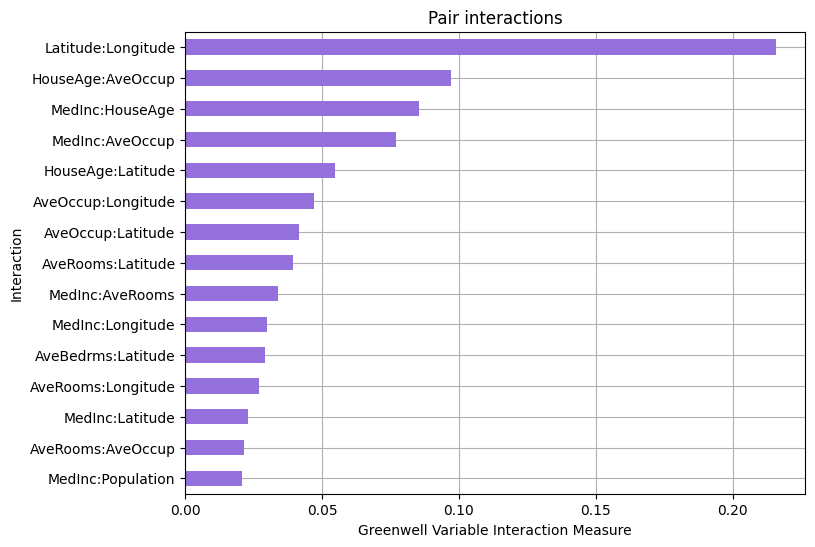

In [17]:
grenwell_method.plot(vis_type='bar_chart', top_k=15)  

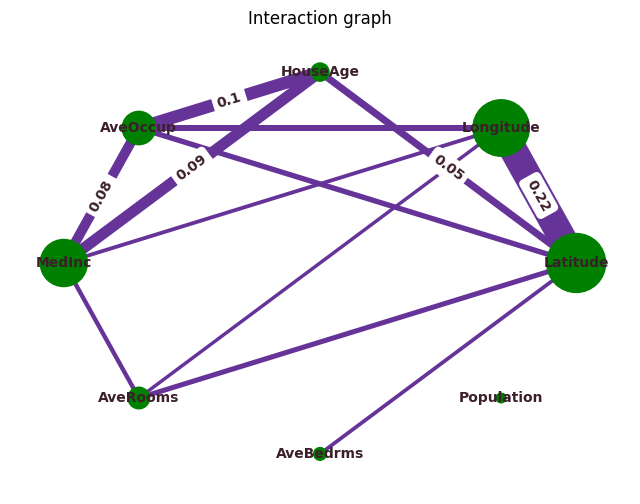

In [18]:
grenwell_method.plot("graph", threshold_relevant_interaction=0.025)

**H-statistic** 

H-statistic is a method introduced by [Friedman and Popescu](https://www.jstor.org/stable/30245114#metadata_info_tab_contents).
It is based on calculating the difference between a two-way partial dependence function and the sum of two one-way partial dependence functions
for both features. The same applies to higher-order interactions. The measure of interaction is the fraction of variance of the partial dependence function explained by the calculated differences.

Since this is also a PD-based method, it is possible to pass the `pd_calculator` object from the previous explanation of this type. This way PD values do not have to be calculated again. 

In [19]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(xgb_model, X_exp, pd_calculator=grenwell_method.pd_calculator) 

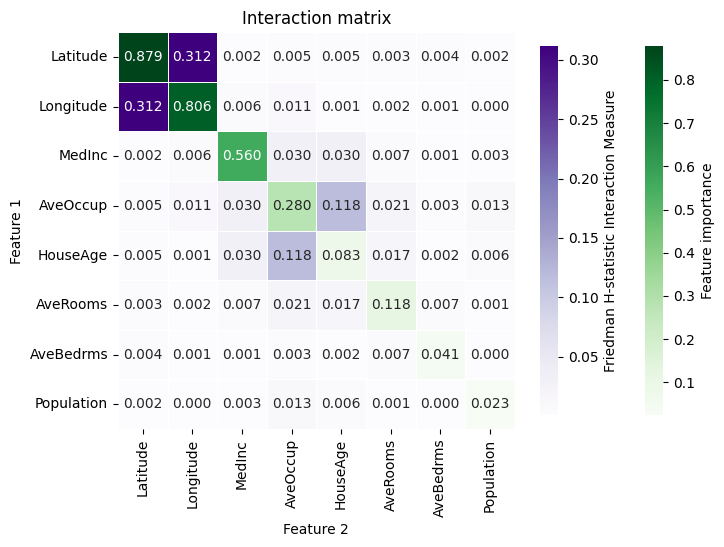

In [20]:
h_stat.plot()

In the case of H-statistic, we also get one vs all interactions (interactions of one specified features with all others). It is available via the `ova` attribute.  

In [21]:
h_stat.ova

,Feature,Friedman H-statistic Interaction Measure
0,Latitude,0.086410
1,Longitude,0.078129
2,AveOccup,0.039642
3,MedInc,0.021714
4,HouseAge,0.017225
5,AveRooms,0.006335
6,AveBedrms,0.002369
7,Population,0.001187


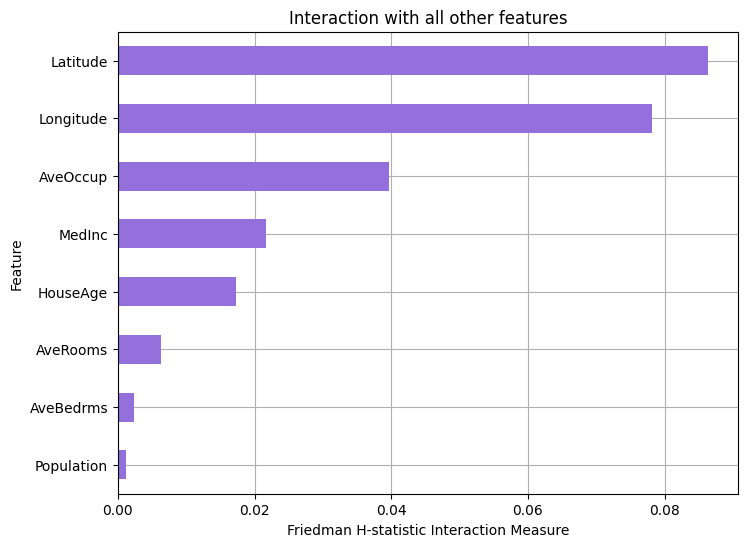

In [22]:
h_stat.plot('bar_chart_ova')

H-statistics also has a modification - unnormalized version. It potentially reduce the number of spurious interactions indicated by
the method.

In [23]:
h_stat_unnormalized = FriedmanHStatisticMethod(normalized=False)
h_stat_unnormalized.fit(xgb_model, X_exp, pd_calculator=grenwell_method.pd_calculator) 

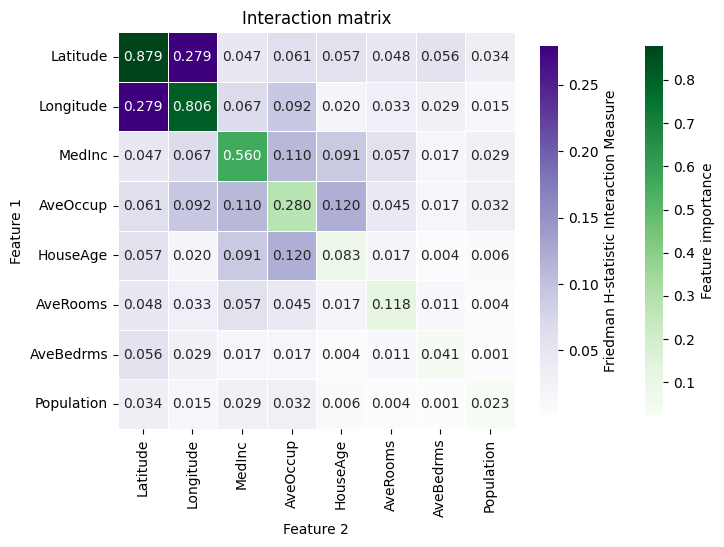

In [24]:
h_stat_unnormalized.plot()

##### Performance based

**Oh method** 

This is an approach introduced by [Oh](https://www.mdpi.com/2076-3417/9/23/5191). It extracts interactions based on prediction performance -- this technique uses permutation feature importance for decomposition similar to H-statistic.

As this method is based on permutation feature importance, it is needed to additionaly provide true target values for observations used for calculating the explanation. 

In [25]:
y_exp = y_test.loc[X_exp.index]

In [26]:
perf_based = SejongOhMethod()
perf_based.fit(xgb_model, X=X_exp, y_true=y_exp, n_repeat=20, show_progress=True) 

Calculating feature importance: 100%|██████████| 20/20 [00:00<00:00, 84.22it/s]


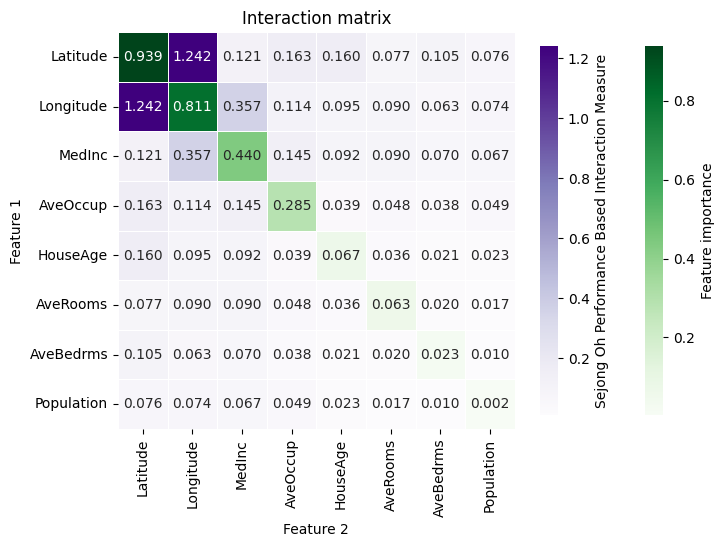

In [27]:
perf_based.plot() 

#### Model-specific explanations

**Split Score method**

This is a method proposed by [Karbowiak and Biecek](https://modeloriented.github.io/EIX/articles/EIX.html). It is suitable for gradient-boosted trees models and used their structure for extracting interactions. Namely, it compares split scores (gain, cover) of consecutive nodes in trees.

In [28]:
split_score = SplitScoreMethod()
split_score.fit(xgb_model, show_progress=True, interaction_selected_metric = "mean_gain")

100%|██████████| 100/100 [00:00<00:00, 118.97it/s]


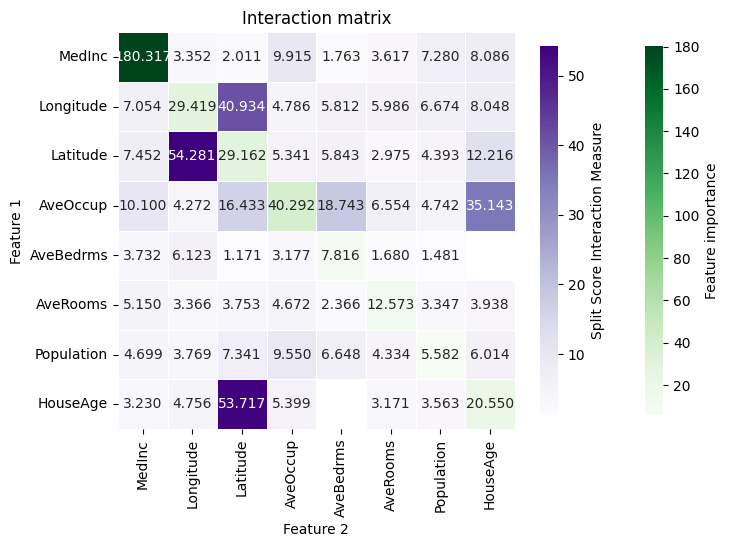

In [29]:
split_score.plot()

An additional visualization showing the structure of the entire model is also provided for this method - it shows split scores of nodes up to a certain depth for the first trees.

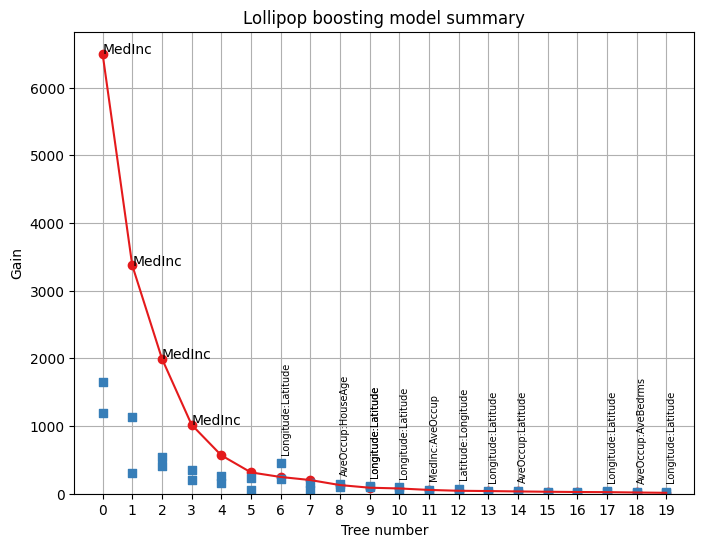

In [30]:
split_score.plot('lollipop', label_threshold = 0.1)

**Conditional Depth method**

This is a method based on the conditional minimal depth concept described by [Ishwaran et al.](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.tm08622).
It is suitable for tree-based ensemble models. The interaction strengths are calculated based on the distance between split nodes for a pair of features in one sub-tree.

In [31]:
cond_depth = ConditionalMinimalDepthMethod()
cond_depth.fit(rf_model, show_progress=True)

100%|██████████| 80/80 [00:00<00:00, 147.74it/s]


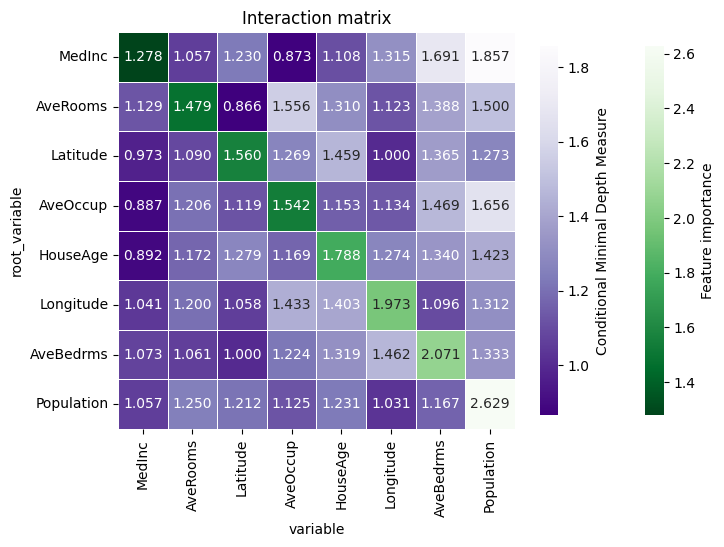

In [32]:
cond_depth.plot()

An additional visualization is also provided for this method - it shows split scores of nodes up to a certain depth for the first trees. Interactions are visualized as bars,
whose color illustrates the number of occurrences of such structures in the trees. The height
of the bar indicates the measure of the interaction – the mean conditional minimal depth. An additional indicator denote the importance of the parent feature –
the mean minimal depth.

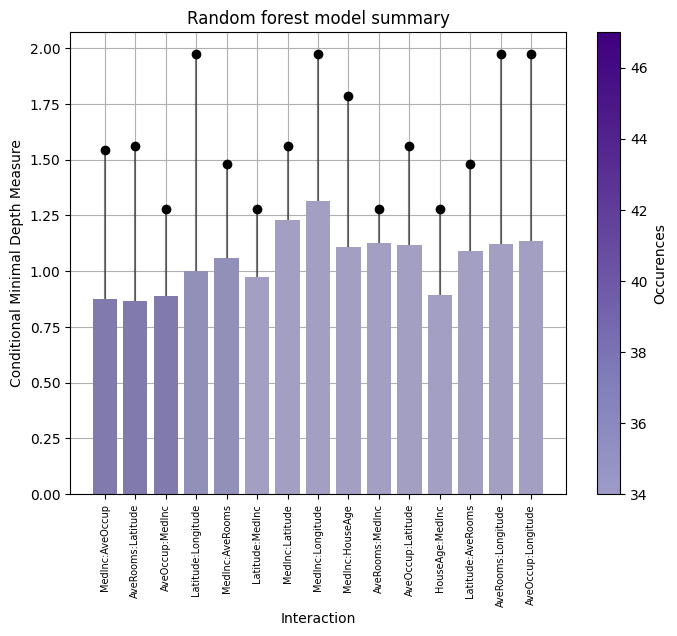

In [33]:
cond_depth.plot('bar_chart_conditional')

### Additional functionalities


One of the key functionalities for partial-dependence-based methods is the visualization of the shape of two-dimensional PD functions, which helps explore the nature of the interactions. This can be done by weaving a so-called zenplot showing the most important interactions in a condensed layout. 

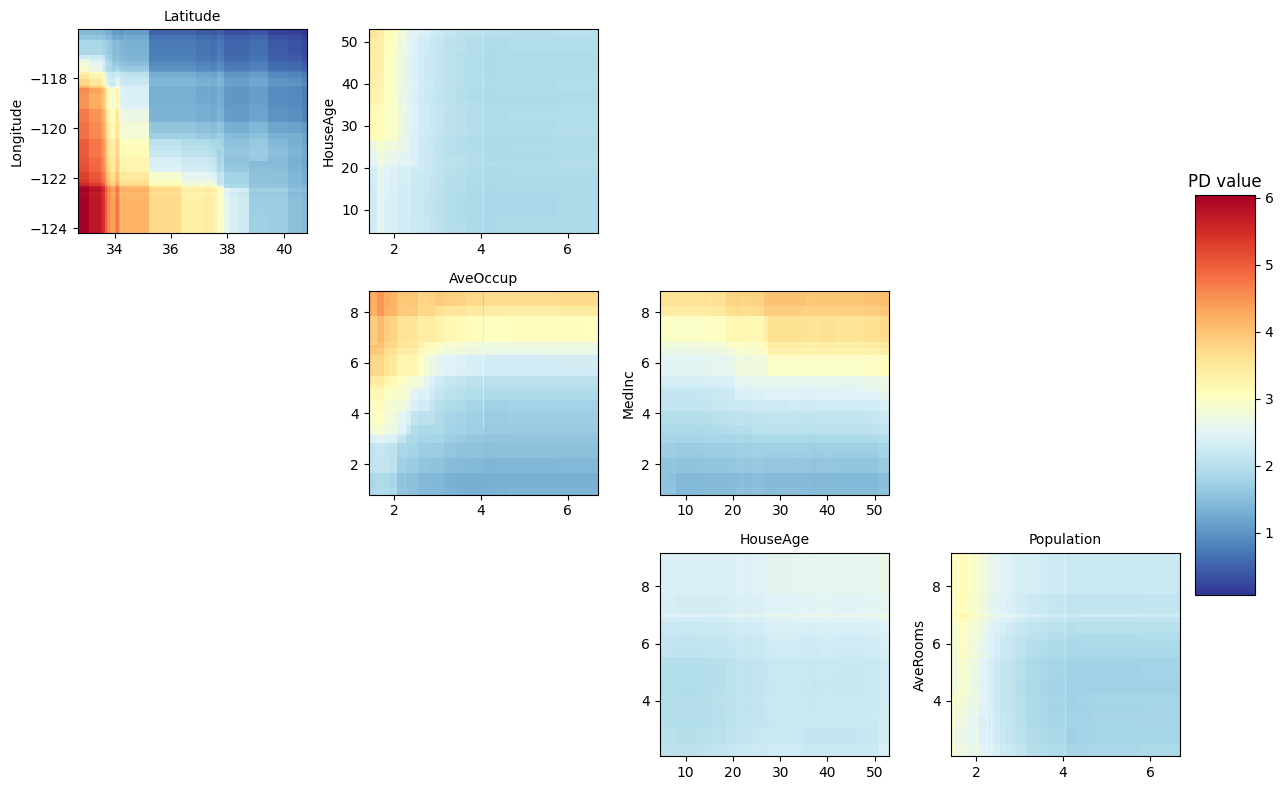

In [34]:
h_stat.plot_zenplot(zenpath_length=6, figsize=(12, 8))

It is also posible to plot a PD function for any selected pair of features.  

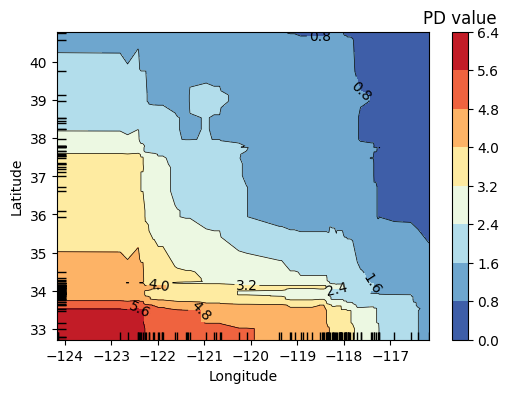

In [35]:
h_stat.plot_profile('Latitude', 'Longitude', kind='contour')

Another capability of the package is to automatically compare the results of explanations obtained by two different methods. 

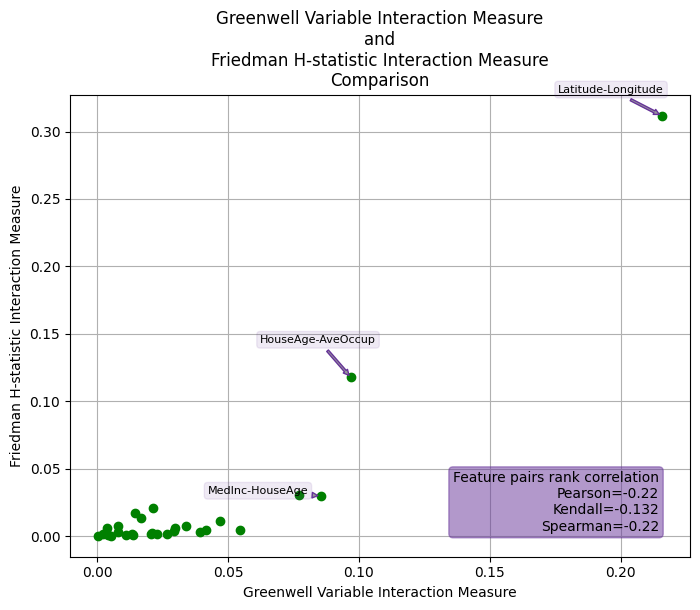

In [36]:
from artemis.comparison import FeatureInteractionMethodComparator
comparator = FeatureInteractionMethodComparator()
comparator.summary(grenwell_method, h_stat)

Another functionality is the ability to calculate the additivity index, which determines the degree of additivity of the model (the maximum value is 1 for a completely additive model). 

In [37]:
from artemis.additivity import AdditivityMeter
add_meter = AdditivityMeter()
X_add = X_test.sample(500) # sample for calculating additivity index

In [38]:
add_xgb = add_meter.fit(xgb_model, X_add)
add_rf = add_meter.fit(rf_model, X_add)
add_lr = add_meter.fit(lr_model, X_add)

In [39]:
add_xgb, add_rf, add_lr 

(0.6330129634848648, 0.965351786651903, 1.0)

The results show that indeed the linear regression is completely additive, with XGBoost containing the most deviations from additivity.  